In [449]:
import os

HOME = os.getcwd()
print(HOME)

INPUTS = '../inputs/outputs'
PRODUCTS = '../inputs/products'
INPUTS

/Users/devasenan/Documents/projects/mfs/overlaying


'../inputs/outputs'

In [2]:
# !git clone https://github.com/devasenan134/mfs.git
# %cp mfs/inputs/outputs ./ -r
# %cp mfs/inputs/products ./ -r
# %rm -rf mfs

# INPUTS = HOME+'/outputs'
# PRODUCTS = HOME+'/products'
# INPUTS

### Functions

In [450]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [451]:
points = []
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(base_image_copy, (x, y), 4, (0, 0, 255), -1)
        points.append([x, y])
        print(points)
        if len(points) <= 4:
            cv2.imshow('image', base_image_copy)
            # plt.imshow(base_image_copy)

In [452]:
def sort_pts(points):
    sorted_pts = np.zeros((4, 2), dtype="float32")
    s = np.sum(points, axis=1)
    sorted_pts[0] = points[np.argmin(s)]
    sorted_pts[2] = points[np.argmax(s)]

    diff = np.diff(points, axis=1)
    sorted_pts[1] = points[np.argmin(diff)]
    sorted_pts[3] = points[np.argmax(diff)]

    return sorted_pts

In [20]:
# cv2.imshow('image', base_image_copy)
# cv2.setMouseCallback('image', click_event)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [453]:
def perspective_warp(base_image, subject_image, polygon):
    sorted_pts = sort_pts(polygon)

    h_base, w_base, c_base = base_image.shape
    h_subject, w_subject = subject_image.shape[:2]

    pts1 = np.float32([[0, 0], [w_subject, 0], [w_subject, h_subject], [0, h_subject]])
    pts2 = np.float32(polygon)

    transformation_matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # print(transformation_matrix)
    warped_img = cv2.warpPerspective(subject_image, transformation_matrix, (w_base, h_base))
    plt.imshow(warped_img)
    
    return warped_img

In [478]:
def combine_warps(base_image, subject_image, polygons):
    combine_warp = np.zeros(base_image.shape, dtype=np.uint8)
    for polygon in polygons:
        warp = perspective_warp(base_image, subject_image, polygon)
        combine_warp = cv2.bitwise_or(combine_warp, warp)
    plt.imshow(combine_warp)

    return combine_warp

In [455]:
def get_mask_imgs(img_path):
    mask_imgs = []
    org_img = ""
    for img in os.listdir(img_path):
        if img.split('.')[-1] == 'png':
            mask_imgs.append(img_path+"/"+img)
        else:
            org_img = img

    mask_imgs.append(img_path+"/"+org_img)
    return mask_imgs

In [456]:
def read_imgs(imgs):
    masks = []
    for img in imgs[:-1]:
        mask = cv2.imread(img, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        print(bw_img.shape)
        # plt.imshow(mask)    
        masks.append(bw_img)    
    return masks

In [479]:
def combine_masks(base_image, bin_masks):
    combine_masks = np.zeros(base_image.shape, dtype=np.uint8)
    for mask in bin_masks:
        combine_masks = cv2.bitwise_or(combine_masks, mask)
    plt.imshow(combine_masks)

    return combine_masks

### Process

In [490]:
sample1 = INPUTS+'/3.jpg'
sample2 = INPUTS+'/img1.jpeg'
sample3 = INPUTS+'/test1.jpg'

sample_paint = PRODUCTS+'/Paints/Orange.jpg'
sample_stone = PRODUCTS+'/Stone/ArmaniBrown.jpg'
sample_wallpaper = PRODUCTS+'/Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg'

In [491]:
# points for sample1 image
r_points=[[332, 327], [330, 1], [1464, 1], [1464, 517]]
l_points = [[6, 2], [330, 1], [332, 327], [4, 409]]

# #sample2 image
# r_points = [[866, 57], [865, 712], [1594, 881], [1594, 2], [1051, 4]]
# l_points = [[866, 57], [865, 712], [680, 3], [4, 3], [5, 978]]

# #sample3 image
# r_points = [[6, 127], [487, 326], [485, 754], [7, 869]]
# m_points = [[487, 326], [1228, 257], [1252, 806], [485, 754]]
# l_points = [[1228, 257], [1363, 3], [1592, 2], [1591, 1036], [1252, 806]]

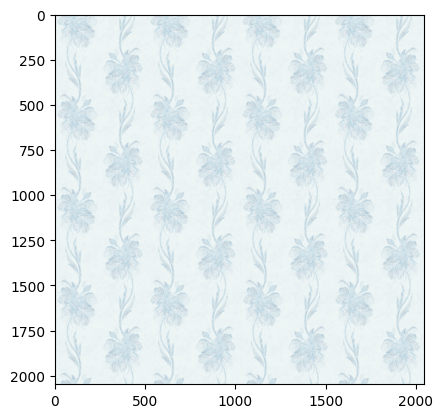

In [492]:
base_image = cv2.imread(sample1)
base_image_copy = base_image.copy()
subject_image = cv2.imread(sample_wallpaper)
plt.imshow(subject_image)

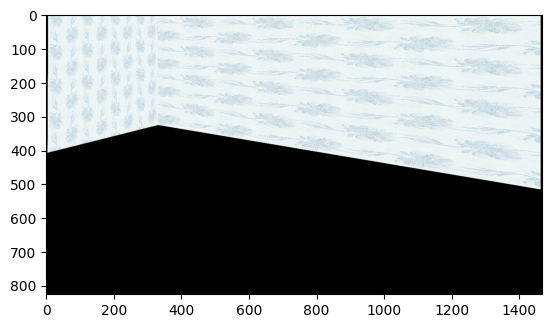

In [493]:
wall_overlay = combine_warps(base_image, subject_image, [r_points, l_points])

In [494]:
img_paths = get_mask_imgs('../inputs/inputs/img0')
print(img_paths)
masks = read_imgs(img_paths)

['../inputs/inputs/img0/wall3.png', '../inputs/inputs/img0/wall2.png', '../inputs/inputs/img0/wall.png', '../inputs/inputs/img0/Floor.png', '../inputs/inputs/img0/3.jpg']
(826, 1468, 3)
(826, 1468, 3)
(826, 1468, 3)
(826, 1468, 3)


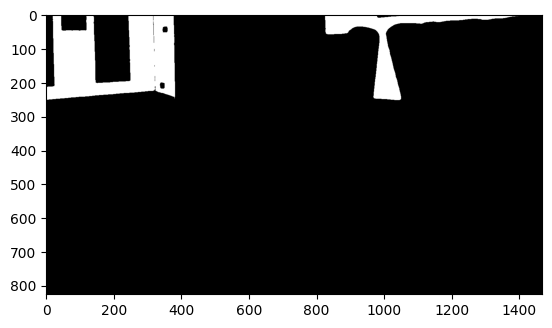

In [495]:
merged_mask = combine_masks(base_image, masks[:3])

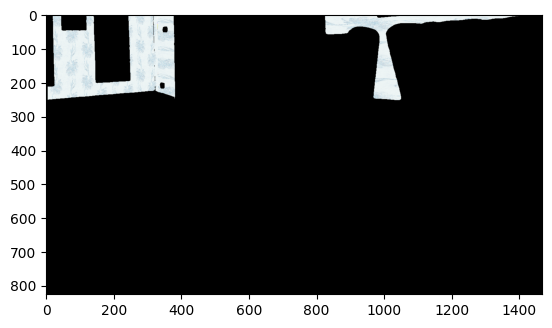

In [496]:
mask_overlay = cv2.bitwise_and(merged_mask, wall_overlay)
plt.imshow(mask_overlay)

(826, 1468)


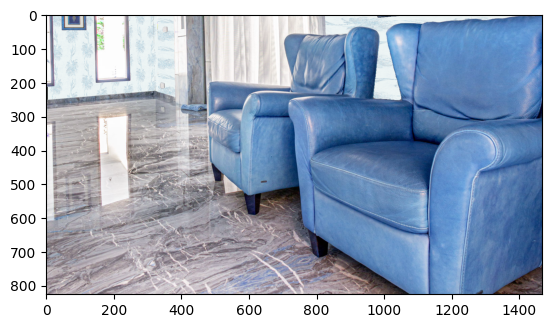

In [497]:
gray_mask = cv2.cvtColor(merged_mask, cv2.COLOR_RGB2GRAY)
print(gray_mask.shape)
#white_coordinates is the space where the mask is selected
white_coordinates = np.where(gray_mask > 0)

src_img = cv2.imread(img_paths[-1])
src_img[white_coordinates] = mask_overlay[white_coordinates]
plt.imshow(src_img)